In [1]:
import cfbd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math

First, we'll grab a 6 year sample of games, from 2015-2020 (you'll see why we're grabbing so many games in a second), then filter out any games not against BCS opponents.

In [2]:
seasons = [cfbd.GamesApi().get_games(year=iteryear, season_type='both') for iteryear in range(2015,2021)]
games = [game for season in seasons for game in season]

In [3]:
games_df = pd.DataFrame().from_records([
                dict(
                    id=g.id, 
                    neutral_site=g.neutral_site,
                    home_team=g.home_team,
                    home_conference=g.home_conference,
                    home_points=g.home_points,
                    away_team=g.away_team,
                    away_conference=g.away_conference,
                    away_points=g.away_points,
                    season=g.season
                ) 
                for g in games 
                if g.home_points is not None 
                    and g.away_points is not None
                    and g.home_conference is not None 
                    and g.away_conference is not None
            ])
games_df.head()

,id,neutral_site,home_team,home_conference,home_points,away_team,away_conference,away_points,season
0,400603840,True,South Carolina,SEC,17,North Carolina,ACC,13,2015
1,400763593,False,UCF,American Athletic,14,Florida International,Conference USA,15,2015
2,400763399,False,Central Michigan,Mid-American,13,Oklahoma State,Big 12,24,2015
3,400603839,False,Vanderbilt,SEC,12,Western Kentucky,Conference USA,14,2015
4,400756883,False,Utah,Pac-12,24,Michigan,Big Ten,17,2015


Our first task to calculate $r_{x}$ for each of these games - the probability that the home team is better than the away team given their margin of victory. 

Kolbush and Sokol instead use a common-opponent approach for estimating $r_{x}$. Essentially, for a given game, we can look at the opponents Team A and Team B both played over the course of the season. Let's walk through an example.

In [4]:
games_df.loc[(games_df['id'] == 401112476)]

,id,neutral_site,home_team,home_conference,home_points,away_team,away_conference,away_points,season
3369,401112476,False,Miami,ACC,35,Virginia Tech,ACC,42,2019


In this example game, Miami lost to Virginia Tech by 7 points. How many opponents did Virginia Tech and Miami have in common that year?

In [5]:
opponents = games_df['away_team'][((games_df['home_team'] == 'Virginia Tech') & (games_df['season'] == 2019))].tolist() + games_df['home_team'][((games_df['away_team'] == 'Virginia Tech') & (games_df['season'] == 2019))].tolist() + games_df['away_team'][((games_df['home_team'] == 'Miami') & (games_df['season'] == 2019))].tolist() + games_df['home_team'][((games_df['away_team'] == 'Miami') & (games_df['season'] == 2019))].tolist()

common_opponents = set([team for team in opponents if opponents.count(team) > 1])

common_opponents

{'Duke', 'Georgia Tech', 'North Carolina', 'Pittsburgh', 'Virginia'}

How well did VT and Miami do against those common opponents?

In [6]:
vt_w = 0
mia_w = 0
vt_g = 0
mia_g = 0
for index, game in games_df.loc[games_df['season'] == 2019].iterrows():
    if (game['home_team'] == 'Virginia Tech') & (game['away_team'] in common_opponents):
        vt_g += 1
        if game['home_points'] > game['away_points']:
            vt_w += 1
    elif (game['home_team'] == 'Miami') & (game['away_team'] in common_opponents):
        mia_g += 1
        if game['home_points'] > game['away_points']:
            mia_w += 1
    elif (game['away_team'] == 'Virginia Tech') & (game['home_team'] in common_opponents):
        vt_g += 1
        if game['away_points'] > game['home_points']:
            vt_w += 1
    elif (game['away_team'] == 'Miami') & (game['home_team'] in common_opponents):
        mia_g += 1
        if game['away_points'] > game['home_points']:
            mia_w += 1
            
print("Virginia Tech's common opponent WPCT: " + str(vt_w / vt_g))
print("Miami's common opponent WPCT: " + str(mia_w / mia_g))

Virginia Tech's common opponent WPCT: 0.6
Miami's common opponent WPCT: 0.4


Virginia Tech won 60% of their games against their common opponents, and Miami won 40%. This renders our calculus rather simple: there is a (0.4 + (1-0.6)) / 2 = 0.4, or 40% approximated chance Miami is better than Virginia Tech.

To obtain a smooth estimate, we'll perform this for every game where teams had common opponents in a season, compile the point differentials for those games, then run a weighted logistic regression on those games (remember, our 40% estimate is independent of point differential - we wish to translate point differential into this estimate!). Our weights will be the total number of games played against common opponents (we can be more confident in our estimate of $r_{x}$ if we have more games.

We'll do this for the 2015-2018 seasons to estimate coefficients for the 2019 season (using the previous 4 years to estimate coefficients for a given season, as Kolbush and Sokol did). We'll also filter out neutral site games, so we can get a better approximation for home field advantage. Just a warning: this will take a while since we're going over basically every game of the past four years, all 3200-ish of them!

In [7]:
train_games_df = games_df.loc[(games_df['season'].isin([2015,2016,2017,2018])) & (~games_df['neutral_site'])]

train_df = []

for index, game in train_games_df.iterrows():
    season = game['season']
    team_a = game['home_team']
    team_b = game['away_team']
    home_diff = game['home_points'] - game['away_points']
    opponents = train_games_df['away_team'][((games_df['home_team'] == team_a) & (games_df['season'] == season))].tolist() + games_df['home_team'][((games_df['away_team'] == team_a) & (games_df['season'] == season))].tolist() + games_df['away_team'][((games_df['home_team'] == team_b) & (games_df['season'] == season))].tolist() + games_df['home_team'][((games_df['away_team'] == team_b) & (games_df['season'] == season))].tolist()
    common_opponents = set([team for team in opponents if opponents.count(team) > 1])
    if len(common_opponents) > 1:
        a_w = 0
        b_w = 0
        a_g = 0
        b_g = 0
        for index, game in games_df.loc[(games_df['season'] == season) & 
                                        ((games_df['home_team'].isin([team_a,team_b])) |
                                          games_df['away_team'].isin([team_a,team_b]))].iterrows():
            if (game['home_team'] == team_a) & (game['away_team'] in common_opponents):
                a_g += 1
                if game['home_points'] > game['away_points']:
                    a_w += 1
            elif (game['home_team'] == team_b) & (game['away_team'] in common_opponents):
                b_g += 1
                if game['home_points'] > game['away_points']:
                    b_w += 1
            elif (game['away_team'] == team_a) & (game['home_team'] in common_opponents):
                a_g += 1
                if game['away_points'] > game['home_points']:
                    a_w += 1
            elif (game['away_team'] == team_b) & (game['home_team'] in common_opponents):
                b_g += 1
                if game['away_points'] > game['home_points']:
                    b_w += 1
        
        r_x = ((a_w / a_g) + (1 - (b_w / b_g))) / 2
        
        d = {
            'season' : season,
            'team_a' : team_a,
            'team_b' : team_b,
            'home_diff' : home_diff,
            'r_x' : r_x,
            'weight' : a_g+b_g
        }
        train_df.append(d)

train_df = pd.DataFrame(train_df)  
train_df.head()

,season,team_a,team_b,home_diff,r_x,weight
0,2015,Tulane,Duke,-30,0.25,4
1,2015,Western Michigan,Michigan State,-13,0.25,4
2,2015,Northwestern,Stanford,10,0.00,4
3,2015,Georgia,Louisiana Monroe,37,0.75,4
4,2015,NC State,Troy,28,0.75,4


Now, we'll use our data to make a logistic regression model. Okay, I lied, it's not a strict logistic regression model - because we have a series of continuous probabilities and their weights rather than a series of 1s and 0s (which a logistic regression model is *usually* trained upon), we're going to use the logit transformation to linearize our data, then run a weighted linar regression model, then undo the logit transformation to obtain probabilities for $r_{x}$. Before we do that, we're going transform any probabilities of 1 to 0.9 and 0 to 0.1 -- the logit transformation can't handle these specific probabilities.

a = 0.023983237378834787
b = -0.09541138612221126


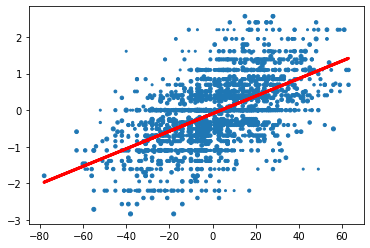

In [8]:
train_df.loc[train_df['r_x'] == 1,'r_x'] = 0.9
train_df.loc[train_df['r_x'] == 0,'r_x'] = 0.1

x = np.array(train_df['home_diff']).reshape(-1,1)
y = np.log(train_df['r_x'] / (1 - train_df['r_x']))
w = train_df['weight']
model = LinearRegression().fit(x, y, w)
plt.scatter(x, y, s = w)
plt.plot(x, model.predict(x), color='red', linewidth=3, label='Weighted model')
a = model.coef_[0]
b = model.intercept_
print("a = " + str(a))
print("b = " + str(b))

Remember that for a linear regression, we find our coefficients in the form $y = ax + b$
. Since $y$ is logit transformed, to undo that transformation, we plug $ax + b$ into $\frac{e^{y}}{1 + e^{y}}$ for $\frac{e^{ax + b}}{1 + e^{ax + b}}$. 

Let's return to that Virginia Tech/Miami game. Based on the point differential of the game and our model, what are the odds that Miami was better than Virginia Tech?

In [9]:
print(math.exp(a * -7 + b) / (1 + math.exp(a * -7 + b)))

0.43455413139478277


Not too far off from our original estimate of 40%!

We can also quickly calculate the expected home field advantage from this dataset:

In [10]:
h = (-b / a)
print(h)

3.978253002924944


So from 2015-2018, home field advantage appears to be worth about 4 points -- not too far off from the 2.5 estimate Bill has been using in his SRS calculations.

Now that we have our formula for estimating $r_{x}$, we can start building our Markov chain. Recall how we did this by hand in part one:

>To generate our transition matrix, we sum up  for games involving a particular team (let's say, Team X) by team. In the row of Team X, we place each team's sum of $r_{x}$ in each team's corresponding column (including Team X). Then, we divide all of the values in the row by the number of games Team X played.

We're going to implement this algorithmically for our 2019 dataset. First, let's grab our 2019 values.

In [11]:
games_df_2019 = games_df.loc[games_df['season'] == 2019]
games_df_2019.head()

,id,neutral_site,home_team,home_conference,home_points,away_team,away_conference,away_points,season
3073,401110723,True,Florida,SEC,24,Miami,ACC,20,2019
3074,401114164,False,Hawai'i,Mountain West,45,Arizona,Pac-12,38,2019
3075,401117854,False,Cincinnati,American Athletic,24,UCLA,Pac-12,14,2019
3076,401114236,False,Tulane,American Athletic,42,Florida International,Conference USA,14,2019
3077,401111653,False,Clemson,ACC,52,Georgia Tech,ACC,14,2019


Next, we'll build two matrices: an n x n transition matrix, where n is the number of BCS teams, and a 1 x n matrix, tracking how many games each team plays.

In [12]:
team_names = sorted(list(set(games_df_2019['home_team'].tolist() + games_df_2019['away_team'].tolist())))
n_teams = len(team_names)
p = np.zeros((n_teams,n_teams))
n_games = np.zeros(n_teams)

Now, we'll iterate through each game, calculate r_x, and put either r_x or 1 - r_x in the appropriate place in our transition matrix (to understand why we're playing each value where we are, consult part one of this guide here]. For neutral-site games, we'll calculate r_x after adding the home-field advantage in. We'll also add a game to each team's n_games counter. 

In [13]:
for index, game in games_df_2019.iterrows():
    home_team = game['home_team']
    away_team = game['away_team']
    home_points = game['home_points']
    away_points = game['away_points']
    neutral_flg = game['neutral_site']
    home_team_ndx = team_names.index(home_team)
    away_team_ndx = team_names.index(away_team)
    spread = home_points - away_points
    if neutral_flg:
        spread += h
    r_x = math.exp(a * spread + b) / (1 + math.exp(a * spread + b))
    n_games[home_team_ndx] += 1
    n_games[away_team_ndx] += 1
    p[home_team_ndx, away_team_ndx] += 1 - r_x
    p[away_team_ndx, home_team_ndx] += r_x
    p[home_team_ndx, home_team_ndx] += r_x
    p[away_team_ndx, away_team_ndx] += 1 - r_x

Next, we'll divide each row our transition by the number of games we're tracking for each team.

In [14]:
p = p / n_games[:,None]
print(p)

[[0.57204818 0.         0.         ... 0.         0.         0.03668326]
 [0.         0.354444   0.         ... 0.         0.         0.        ]
 [0.         0.         0.64208189 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.52879391 0.         0.        ]
 [0.         0.         0.         ... 0.         0.59096999 0.        ]
 [0.04665007 0.         0.         ... 0.         0.         0.54762383]]


Finally, we'll approximate the steady state of this matrix to find what team LRMC believes is the best.

In [15]:
prior = n_teams - np.array(list(range(n_teams)))
steady_state = np.linalg.matrix_power(p, 1000)
rating = prior.dot(steady_state)
rating_df = pd.DataFrame({
    'team': team_names,
    'lrmc_rating': rating
    
})
print(rating_df.sort_values(by=['lrmc_rating'], ascending=False).iloc[0:25])

                  team  lrmc_rating
77          Ohio State   187.106455
48                 LSU   175.945528
21             Clemson   157.969142
128          Wisconsin   130.052698
2              Alabama   129.821806
34             Georgia   118.031678
82              Oregon   115.817995
78            Oklahoma   110.981205
9               Auburn   108.585276
75          Notre Dame   107.732058
59            Michigan   106.242719
117               Utah   105.915359
84          Penn State   105.042793
12              Baylor   103.884959
101              Texas   101.253766
42                Iowa   100.165017
29             Florida    96.009519
56             Memphis    93.568406
62           Minnesota    90.033058
20          Cincinnati    89.598700
123         Washington    88.540195
43          Iowa State    88.377904
3    Appalachian State    86.243448
110                UCF    86.078021
102          Texas A&M    84.039906


So we've finished with LRMC rankings with 2019 -- but how will they work in the messed-up year of 2020, when some teams are playing conference-only games? Let's find out. We'll re-run the same analysis but for home games, but we'll adjust home field advantage for the weird-pandemic stuff, eyeballing it and dropping it by 1 point -- remove some to account for the impact of reduced or no crowd, but keeping some to account for rest/travel.

In [16]:
train_games_df = games_df.loc[(games_df['season'].isin([2016,2017,2018,2019])) & (~games_df['neutral_site'])]

train_df = []

for index, game in train_games_df.iterrows():
    season = game['season']
    team_a = game['home_team']
    team_b = game['away_team']
    home_diff = game['home_points'] - game['away_points']
    opponents = train_games_df['away_team'][((games_df['home_team'] == team_a) & (games_df['season'] == season))].tolist() + games_df['home_team'][((games_df['away_team'] == team_a) & (games_df['season'] == season))].tolist() + games_df['away_team'][((games_df['home_team'] == team_b) & (games_df['season'] == season))].tolist() + games_df['home_team'][((games_df['away_team'] == team_b) & (games_df['season'] == season))].tolist()
    common_opponents = set([team for team in opponents if opponents.count(team) > 1])
    if len(common_opponents) > 1:
        a_w = 0
        b_w = 0
        a_g = 0
        b_g = 0
        for index, game in games_df.loc[(games_df['season'] == season) & 
                                        ((games_df['home_team'].isin([team_a,team_b])) |
                                          games_df['away_team'].isin([team_a,team_b]))].iterrows():
            if (game['home_team'] == team_a) & (game['away_team'] in common_opponents):
                a_g += 1
                if game['home_points'] > game['away_points']:
                    a_w += 1
            elif (game['home_team'] == team_b) & (game['away_team'] in common_opponents):
                b_g += 1
                if game['home_points'] > game['away_points']:
                    b_w += 1
            elif (game['away_team'] == team_a) & (game['home_team'] in common_opponents):
                a_g += 1
                if game['away_points'] > game['home_points']:
                    a_w += 1
            elif (game['away_team'] == team_b) & (game['home_team'] in common_opponents):
                b_g += 1
                if game['away_points'] > game['home_points']:
                    b_w += 1
        
        r_x = ((a_w / a_g) + (1 - (b_w / b_g))) / 2
        
        d = {
            'season' : season,
            'team_a' : team_a,
            'team_b' : team_b,
            'home_diff' : home_diff,
            'r_x' : r_x,
            'weight' : a_g+b_g
        }
        train_df.append(d)

train_df = pd.DataFrame(train_df)
train_df.loc[train_df['r_x'] == 1,'r_x'] = 0.9
train_df.loc[train_df['r_x'] == 0,'r_x'] = 0.1

x = np.array(train_df['home_diff']).reshape(-1,1)
y = np.log(train_df['r_x'] / (1 - train_df['r_x']))
w = train_df['weight']
model = LinearRegression().fit(x, y, w)
a = model.coef_[0]
b = model.intercept_
h = (-b / a) - 2

games_df_2020 = games_df.loc[games_df['season'] == 2020]
games_df_2020.head()

team_names = sorted(list(set(games_df_2020['home_team'].tolist() + games_df_2020['away_team'].tolist())))
n_teams = len(team_names)
p = np.zeros((n_teams,n_teams))
n_games = np.zeros(n_teams)

for index, game in games_df_2020.iterrows():
    home_team = game['home_team']
    away_team = game['away_team']
    home_points = game['home_points']
    away_points = game['away_points']
    neutral_flg = game['neutral_site']
    home_team_ndx = team_names.index(home_team)
    away_team_ndx = team_names.index(away_team)
    spread = home_points - away_points
    if neutral_flg:
        spread += h
    r_x = math.exp(a * spread + b) / (1 + math.exp(a * spread + b))
    n_games[home_team_ndx] += 1
    n_games[away_team_ndx] += 1
    p[home_team_ndx, away_team_ndx] += 1 - r_x
    p[away_team_ndx, home_team_ndx] += r_x
    p[home_team_ndx, home_team_ndx] += r_x
    p[away_team_ndx, away_team_ndx] += 1 - r_x
    
p = p / n_games[:,None]
prior = n_teams - np.array(list(range(n_teams)))
steady_state = np.linalg.matrix_power(p, 1000)
rating = prior.dot(steady_state)
rating_df = pd.DataFrame({
    'team': team_names,
    'lrmc_rating': rating
    
})
print(rating_df.sort_values(by=['lrmc_rating'], ascending=False).iloc[0:25])

                  team  lrmc_rating
2              Alabama   135.230015
16             Buffalo   131.356858
21             Clemson   130.404969
73          Notre Dame   129.633899
10                 BYU   129.319638
22    Coastal Carolina   113.635301
42          Iowa State   110.743776
49           Louisiana   109.852425
107                UCF   105.703515
20          Cincinnati   104.514956
69      North Carolina   103.885852
124   Western Michigan   103.099373
76            Oklahoma   100.090273
104             Tulane    99.269570
18    Central Michigan    99.083950
28             Florida    98.579495
14      Boston College    97.503712
56               Miami    96.908824
102             Toledo    96.386918
64            NC State    95.923478
52          Louisville    94.467302
98               Texas    93.446952
3    Appalachian State    93.341825
118      Virginia Tech    92.720235
33             Georgia    92.415851
